In [92]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 4.2)
plt.rcParams["axes.grid"] = True

In [93]:
df_qc = pd.read_csv("CSVData/df_qc.csv", parse_dates=["date"])

In [94]:
def _log1p(y):
    y = np.asarray(y, dtype="float64")
    y = np.where(np.isfinite(y), y, np.nan)
    y = np.clip(y, 0, None)  # clorofila proxy no negativa
    return np.log1p(y)

def _exp1m(x):
    return np.expm1(x)

def seasonal_naive(y, H=14, s=7):
    """Copia los últimos s valores para predecir los próximos H (naive estacional)."""
    y = pd.Series(y).dropna()
    if len(y) < s:
        return np.repeat(y.iloc[-1], H)
    last_season = y.iloc[-s:].values
    reps = int(np.ceil(H / s))
    return np.tile(last_season, reps)[:H]

In [95]:
def sarimax_gridsearch(y_log, s=7):
    """Devuelve (order, sorder, fitted_results) con el menor AIC; None si todos fallan."""
    orders   = [(1,0,0),(1,0,1),(2,0,1),(1,1,1)]
    sorders  = [(0,1,1),(1,0,1),(1,1,0)]
    best = (None, None, None, np.inf)
    for (p,d,q) in orders:
        for (P,D,Q) in sorders:
            try:
                mod = SARIMAX(
                    y_log, order=(p,d,q), seasonal_order=(P,D,Q,s),
                    trend="n", enforce_stationarity=False, enforce_invertibility=False
                )
                res = mod.fit(disp=False)
                if res.aic < best[3]:
                    best = ((p,d,q), (P,D,Q), res, res.aic)
            except Exception:
                continue
    return best[:3]  # (order, sorder, results) o (None, None, None)

In [96]:
def fit_and_forecast_one_series(y, dates, horizon=14, s=7, backtest_len=14, plot_title=""):
    """
    y: serie (float), dates: índice datetime (misma long.), horizon: días a predecir.
    - Hace validación simple (últimos 'backtest_len' días como test).
    - Re-ajusta en todo el histórico y pronostica 'horizon' días futuros.
    """
    ser = pd.Series(y, index=pd.DatetimeIndex(dates)).asfreq("D")
    ser = ser.astype("float64")

    # Split para validación
    train = ser.iloc[:-backtest_len] if backtest_len < len(ser) else ser.iloc[:-1]
    test  = ser.iloc[-backtest_len:]

    # Log-transform
    ytr_log = pd.Series(_log1p(train.values), index=train.index)

    # Grid-search SARIMAX
    order, sorder, res = sarimax_gridsearch(ytr_log.dropna(), s=s)

    # Fallback si no hay modelo
    if res is None:
        yhat_val = seasonal_naive(train.values, H=len(test), s=s)
        mae = mean_absolute_error(test, yhat_val)
        rmse = mean_squared_error(test, yhat_val, squared=False)
        print(f"[{plot_title}] Fallback seasonal-naive | Validación: MAE={mae:.3f}, RMSE={rmse:.3f}")
        # Pronóstico final
        yhat_future = seasonal_naive(ser.values, H=horizon, s=s)
        fut_idx = pd.date_range(ser.index[-1] + pd.Timedelta(days=1), periods=horizon, freq="D")
        return pd.Series(yhat_future, index=fut_idx), None

    # Validación con el modelo hallado
    try:
        # Re-fit en train
        mod = SARIMAX(_log1p(train.values), order=order, seasonal_order=(*sorder, s),
                      trend="n", enforce_stationarity=False, enforce_invertibility=False)
        res_tr = mod.fit(disp=False)
        pred = res_tr.get_forecast(steps=len(test))
        yhat_val = _exp1m(pred.predicted_mean)
        mae = mean_absolute_error(test, yhat_val)
        rmse = mean_squared_error(test, yhat_val)
        print(f"[{plot_title}] SARIMAX{order}x{sorder}{s} | Validación: MAE={mae:.3f}, RMSE={rmse:.3f}")
    except Exception:
        # fallback en validación
        yhat_val = seasonal_naive(train.values, H=len(test), s=s)
        mae = mean_absolute_error(test, yhat_val)
        rmse = mean_squared_error(test, yhat_val)
        print(f"[{plot_title}] (fallback en validación) MAE={mae:.3f}, RMSE={rmse:.3f}")

    # Re-ajuste en TODO el histórico y pronóstico futuro
    mod_full = SARIMAX(_log1p(ser.values), order=order, seasonal_order=(*sorder, s),
                       trend="n", enforce_stationarity=False, enforce_invertibility=False)
    res_full = mod_full.fit(disp=False)
    fc = res_full.get_forecast(steps=horizon)
    yhat_future = _exp1m(fc.predicted_mean)
    fut_idx = pd.date_range(ser.index[-1] + pd.Timedelta(days=1), periods=horizon, freq="D")
    return pd.Series(yhat_future, index=fut_idx), res_full

In [97]:
def plot_fit_and_forecast(y, dates, yhat_future, lake_name, tail_days=90):
    ser = pd.Series(y, index=pd.DatetimeIndex(dates)).asfreq("D")
    # Mostrar la cola del histórico y el pronóstico
    tail = ser.iloc[-tail_days:] if len(ser) > tail_days else ser
    plt.figure()
    plt.plot(tail.index, tail.values, label="observado", lw=1.8)
    plt.plot(yhat_future.index, yhat_future.values, label="pronóstico", lw=2)
    plt.title(f"{lake_name}: índice de cianobacteria (proxy) — observado vs pronóstico")
    plt.xlabel("fecha"); plt.ylabel("chl (proxy)"); plt.legend(); plt.tight_layout(); plt.show()

In [98]:
# Parámetros
HORIZON = 14   # días a predecir hacia adelante
S = 7          # estacionalidad semanal
BT_LEN = 14    # tamaño del bloque de validación

c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab04-DS\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[amatitlan] SARIMAX(1, 1, 1)x(1, 0, 1)7 | Validación: MAE=1.119, RMSE=3.539


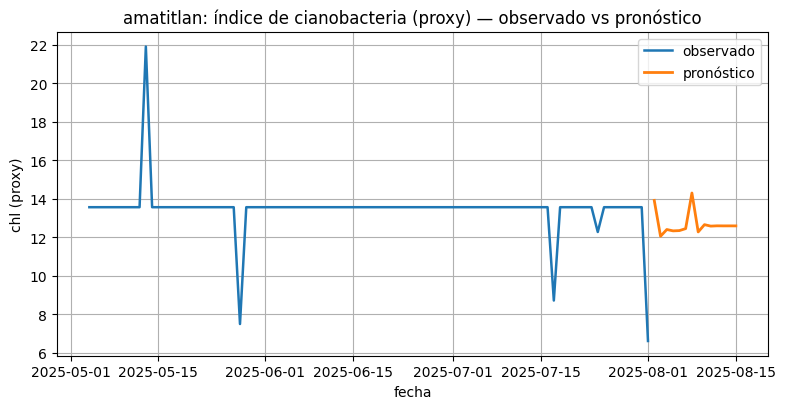

c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab04-DS\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[atitlan] SARIMAX(1, 0, 1)x(1, 0, 1)7 | Validación: MAE=0.313, RMSE=0.534


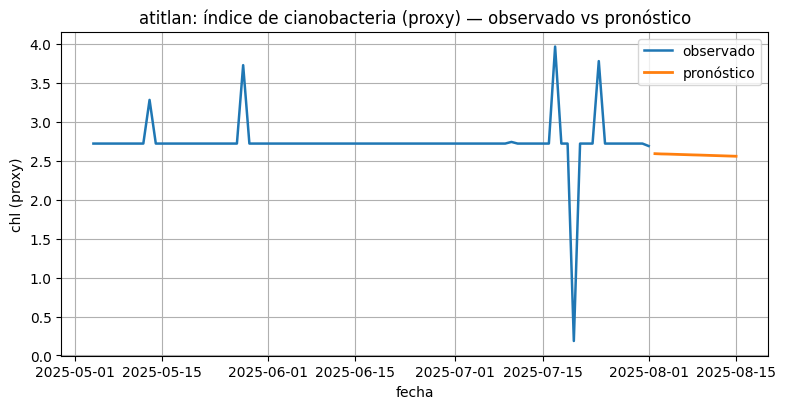

In [99]:
# Asegura tipos
df_qc = df_qc.copy()
df_qc["date"] = pd.to_datetime(df_qc["date"])

forecasts = {}

for lake in sorted(df_qc["lake"].unique()):
    g = df_qc[df_qc["lake"] == lake].sort_values("date")
    y  = g["chl_mean_clip0"].astype(float).values
    dt = g["date"].values

    yhat_future, fit_res = fit_and_forecast_one_series(
        y, dt, horizon=HORIZON, s=S, backtest_len=BT_LEN, plot_title=lake
    )
    forecasts[lake] = yhat_future

    plot_fit_and_forecast(y, dt, yhat_future, lake_name=lake, tail_days=90)

In [100]:
for lake, fc in forecasts.items():
    print(lake, fc.head(), sep="\n", end="\n\n")

amatitlan
2025-08-02    13.905163
2025-08-03    12.043743
2025-08-04    12.393171
2025-08-05    12.323187
2025-08-06    12.337028
Freq: D, dtype: float64

atitlan
2025-08-02    2.589904
2025-08-03    2.586313
2025-08-04    2.584635
2025-08-05    2.582006
2025-08-06    2.579380
Freq: D, dtype: float64



### **Lago Atitlán**

**Gráfico 1**

#### Observaciones:

1. **Serie Observada (azul)**:

   * La mayoría del tiempo el índice permanece **estable** en un valor cercano a 2.7.
   * Hay **picos ocasionales**, uno cerca del **13 de mayo** y otro el **finales de mayo/inicio de junio**, lo que puede indicar presencia temporal de floración.
   * Un **valor negativo o cercano a cero** aparece a mediados de julio, lo cual puede ser un **error de lectura** o un artefacto de los datos satelitales o del índice.

2. **Serie Pronosticada (naranja)**:

   * Comienza alrededor de **finales de julio**.
   * Se observa una predicción **estable y descendente** hacia mediados de agosto, alrededor de 2.6.
   * No hay presencia de picos, lo que podría indicar que el modelo no está capturando bien los **eventos abruptos** o **anómalos**.

#### Comentario:

* El modelo de predicción parece **demasiado conservador**: suaviza y subestima los picos de floración.
* Puede deberse a un **modelo SARIMA poco sensible** a cambios abruptos o al hecho de que el proxy de cianobacteria tiene pocos valores extremos (es poco variable).
* Aun así, si la intención es capturar la **tendencia general** del lago, **cumple aceptablemente**.

---

### **Lago Amatitlán**

**Gráfico 2**

#### Observaciones:

1. **Serie Observada (azul)**:

   * Se observa un **pico muy alto (\~22)** en **principios de mayo**, lo que indica una **floración severa** de cianobacteria.
   * Luego hay una fase **estable alrededor de 13–14**, hasta que cae brevemente a valores de \~8 a fines de mayo.
   * Nuevos **descensos bruscos** ocurren a mediados de julio (\~9) y a fines de julio (\~6).

2. **Serie Pronosticada (naranja)**:

   * Comienza tras el último dato observado (julio) y muestra **pequeñas oscilaciones** entre 12.5 y 14.
   * No captura los **descensos bruscos** que tuvo la serie observada en la parte final.

#### Comentario:

* El modelo predice una floración **moderada** y **estable**, sin capturar variabilidad reciente.
* En este caso, el modelo **no refleja bien los eventos recientes** de caída abrupta del índice.
* Puede sugerir:

  * Que el modelo necesita incorporar **otras variables** (como temperatura, lluvias o viento).
  * Que es muy dependiente del patrón **promedio pasado** y no reacciona a anomalías.
* También hay posibilidad de que el índice tenga **saturación o errores** en los días con valores anómalos.